# Facial Features

This model uses an input of 224x112

### Imports

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from pynq_dpu import DpuOverlay

### DPU

In [2]:
overlay = DpuOverlay("dpu.bit")
overlay.load_model("face_landmark.xmodel")

In [3]:
dpu = overlay.runner

### Tensors

These are some tensors that we can use.

In [4]:
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()
print(inputTensors[0].dims)

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)


[1, 96, 72, 3]


cool stuff is happening here.

In [256]:
def plot_images(original_image, processed_image, disp_size=(20,20)):
    plt.figure(figsize=disp_size)
    plt.subplot(121),plt.imshow(original_image),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(processed_image),plt.title('Processed')
    plt.xticks([]), plt.yticks([])
    plt.show()

def central_crop(image, crop_height, crop_width):
    image_height = image.shape[0]
    image_width = image.shape[1]
    offset_height = (image_height - crop_height) // 2
    offset_width = (image_width - crop_width) // 2
    image_crop = image[offset_height:offset_height + crop_height, offset_width:
                 offset_width + crop_width, :]
    return image_crop
# This function resizes the image with unchanged aspect ratio using padding.
def letterbox_image(image, size):
    ih, iw, _ = image.shape
    w, h = size
    scale = min(w/iw, h/ih)
    
    nw = int(iw*scale)
    nh = int(ih*scale)

    image = cv2.resize(image, (nw,nh), interpolation=cv2.INTER_LINEAR)
    new_image = np.ones((h,w,3), np.uint8) * 128
    h_start = (h-nh)//2
    w_start = (w-nw)//2
    new_image[h_start:h_start+nh, w_start:w_start+nw, :] = image
    return new_image


def get_dims(matrix, dims=[], layer=0, disp=0, name=None):
    
    if layer == 0: dims=[] # reset dimention array
        
    if type(matrix) in (np.float32, np.uint8, float, int): # if on final layer, return data
        if (disp >= 1):
            if name != None:
                print(f"{name}")  
            print(f"Tensor Dimentions: {dims}")
            print("+----------------------------+")
        return dims
    else:
        dims.append(len(matrix))
        if layer == 0:
            print("+----------------------------+")
        if disp == 2:
            print(f"  Dimention {layer}: ")
            print(f"    Type: {type(matrix)}")
            print(f"    Length: {len(matrix)}")
            print("--------------------")
        return get_dims(matrix[0], dims, layer+1, disp=disp, name=name)
    
    
def preprocess_fn(image, shape = (96, 72), mode='resize', verbose=False):
    image = image.astype(np.float32)
    image =  image / 255.0
    
    
    if mode == 'c_crop':
        if verbose:
            print(f"***** Resizing Image (mode:{mode}) *****")
            get_dims(image, disp=1, name="Before Resize")
        resized_img = central_crop(image, shape[0],shape[1])
    elif mode == 'resize':
        if verbose:
            print(f"***** Resizing Image (mode:{mode}) *****")
            get_dims(image, disp=1, name="Before Resize")
        resized_img = cv.resize(image, (shape[1],shape[0])) # for some reason cv.resize swaps shape values 
    else:
        if verbose:
            print(f"***** Resizing Image (unrecognised mode {mode}. defaulting 'resize') *****")
            get_dims(image, disp=1, name="Before Resize")
        resized_img = cv.resize(image, (shape[1],shape[0]))
        
    if verbose:
        get_dims(resized_img, disp=1, name="After Resize")

    return resized_img


In [316]:
def run(image, display=True, verbose=False, preproc_mode="resize"):
    
    SHAPE = (96,72)
    
    if verbose: get_dims(image, disp=1, name="Input Image")
    
    # Display the image
    plt.figure(figsize=(5, 5))
    plt.subplot(122)
    plt.imshow(image)
    
    
    resized_img = preprocess_fn(image, shape = SHAPE, mode =preproc_mode, verbose=verbose)
    
    
    if verbose: print(f"***** Runnning Inference *****")
    input_data[0][0] = resized_img
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    if verbose: get_dims(output_data, disp=1, name="Output")

    if(display==True):
        width = SHAPE[0]
        height = SHAPE[1]
        
        # Display the image
        plt.figure(figsize=(5, 5))
        plt.subplot(122)
        plt.imshow(resized_img)  #origin='lower'
        
        out_arr = output_data[0][0]
        
        # Plot points on top of the image
        for i in range(0, len(out_arr), 2):
            x = out_arr[i]
            y = out_arr[i+1]
            plt.scatter(x*width, y*height, color='red', marker='o')  # Adjust marker and color as needed

        for i in range(0, int(len(out_arr)/2)):
            x = out_arr[i]
            y = out_arr[i+int(len(out_arr)/2)]
            plt.scatter(x*width, y*height, color='yellow', marker='x')  # Adjust marker and color as needed
            
        for i in range(0, len(out_arr), 2):
            y = out_arr[i]
            x = out_arr[i+1]
            plt.scatter(x*width, y*height, color='blue', marker='o')  # Adjust marker and color as needed

        for i in range(0, int(len(out_arr)/2)):
            y = out_arr[i]
            x = out_arr[i+int(len(out_arr)/2)]
            plt.scatter(x*width, y*height, color='green', marker='x')  # Adjust marker and color as needed

        #plt.show()
    return out_arr


+----------------------------+
Input Image
Tensor Dimentions: [148, 221, 3]
+----------------------------+
[0.359375  0.6484375 0.453125  0.3125    0.5625    0.3984375 0.4140625
 0.609375  0.7109375 0.7265625]
[0.3359375 0.7109375 0.5390625 0.3671875 0.6953125 0.375     0.3359375
 0.609375  0.7421875 0.71875  ]
[0.2890625 0.5703125 0.3515625 0.3203125 0.5390625 0.40625   0.3671875
 0.5625    0.71875   0.6953125]


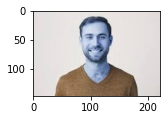

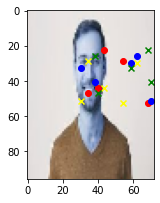

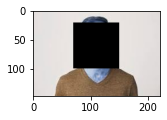

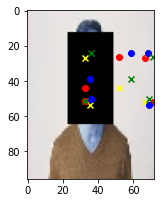

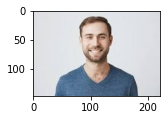

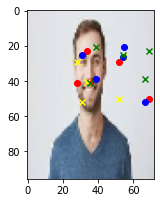

In [317]:
img = cv.imread('img/face.jpg')
rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 

input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
get_dims(img, disp=1, name="Input Image")
#get_dims(input_data, disp=1, name="Input Data")
#get_dims(output_data, disp=1, name="Output Data")
#print(img [0][0][0])

print(run(img, verbose=False, preproc_mode='resize'))

coord = [20,70]
for h in range (0,80):
    for w in range (0,80):
        img[coord[0]+h][coord[1]+w] = [0,0,0]

print(run(img, verbose=False, preproc_mode='resize'))

print(run(rgb_img, verbose=False, preproc_mode='resize'))
#print(run(np.flipud(img), verbose=False, preproc_mode='resize'))

In [318]:
image[0,...] = resized_img
job_id = dpu.execute_async(input_data, output_data)
dpu.wait(job_id)

out_arr = output_data[0][0]

NameError: name 'resized_img' is not defined

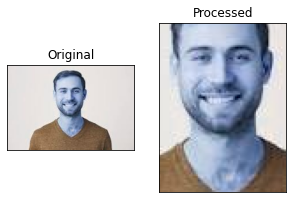

Size of original image:  (148, 221, 3)
Size of resized image:  (96, 72, 3)


In [60]:
height, width = (96,72)
resized_img = central_crop(img, height, width)
plot_images(img, resized_img, disp_size=(5,5))

#plot_images(img,resized_img)
print("Size of original image: ", img.shape)
print("Size of resized image: ", resized_img.shape)

In [ ]:
del overlay
del dpu
